# Description

This notebook will using data saved from data preprare notebook, select and reselect features and fit train/test data with xgboost models and calculate RMSLE

# Import Library

In [83]:
import glob

import pandas as pd
import numpy as np

import xgboost
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

 # Define helper function

In [84]:
 def get_train_test(data_path, features):
    train_features = {}
    test_features = {}
    # Import data
    print('Importing')
    for file_path in glob.glob(data_path + "/*.csv"):
        if file_path[15:-4] == 'DaysInHos_Y2':
            train_y = pd.read_csv(file_path)
        elif file_path[15:-4] == 'DaysInHos_Y3':
            test_y = pd.read_csv(file_path)
        elif file_path[15:-7] in features:
            if file_path[-5] == '1':
                train_features[file_path[15:-7]]= pd.read_csv(file_path)
            elif file_path[-5] == '2':
                test_features[file_path[15:-7]]= pd.read_csv(file_path)
            else:  # MemInfo
                test_features[file_path[15:-7]]= pd.read_csv(file_path)
                train_features[file_path[15:-7]]= pd.read_csv(file_path)
    # Split data
    print('Splitting Train/Test')
    train_x = train_features[features[0]]
    for feature, df in train_features.items():
        if feature != features[0]:
            train_x = train_x.merge(df, left_on='MemberID', right_on='MemberID')
    
    test_x = test_features[features[0]]
    for feature, df in test_features.items():
        if feature != features[0]:
            test_x = test_x.merge(df, left_on='MemberID', right_on='MemberID')
    print('Done')
    return train_x, train_y, test_x, test_y        

In [85]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [86]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [87]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

# Import converted Data

In [161]:
features = [
    'Claims_count',
    'MemberInfo',
    'DrugCount',
    'LabCount',
    'Charlson',
    'DSFS',
    'LOS',
    'PayDelay',
    'PCPs',
    'PlaceSvc',
    'PrimCondition',
    'Procedures',
    'Providers',
    'Specialty',
    'Vendors'
           ]
# Import and get train/test
train_x, train_y, test_x, test_y = get_train_test('processed_data', features)

Importing
Splitting Train/Test
Done


# Features reselect

## 1. Drop MemberID record that DrugCount had been truncated

In [127]:
# Import csv file
DrugCount_df = pd.read_csv('data/hhp_release3/DrugCount.csv').query("Year == 'Y1'")

# Get ID of Member have DrugCount Truncated
truncated_DrugCount = DrugCount_df[DrugCount_df.DrugCount == '7+'].MemberID.unique()

In [162]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_DrugCount)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_DrugCount)].index, inplace=True)

## 2. Drop MemberID record that LabCount had been truncated

In [119]:
# Import csv file
LabCount_df = pd.read_csv('data/hhp_release3/LabCount.csv').query("Year == 'Y1'")

# Get ID of Member have LabCount Truncated
truncated_LabCount = LabCount_df[LabCount_df.LabCount == '10+'].MemberID.unique()

In [163]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_LabCount)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_LabCount)].index, inplace=True)

## 3. Drop MemberID record that SupLOS == 1

In [133]:
truncated_SupLOS = train_x[train_x.SupLOS_nan == 1].MemberID.unique()

In [164]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_SupLOS)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_SupLOS)].index, inplace=True)

# Drop SupLOS column
train_x.drop(columns=['SupLOS_nan'], inplace=True)
test_x.drop(columns=['SupLOS_nan'], inplace=True)

## 4. Drop MemberID record that ClaimsCount > 42

In [140]:
truncated_ClaimsCount = train_x[train_x.ClaimsCount == 43].MemberID.unique()

In [165]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_ClaimsCount)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_ClaimsCount)].index, inplace=True)

## 5. Drop MemberID record that PayDelay have been truncated

In [147]:
claims_Y1 = pd.read_csv('data/hhp_release3/Claims.csv').query("Year == 'Y1'")
truncated_PayDelay = claims_Y1[claims_Y1.PayDelay == '162+'].MemberID.unique()

In [166]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_PayDelay)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_PayDelay)].index, inplace=True)

## 6. Drop MemberID record that claims have been other truncated

In [155]:
truncated_Claims = train_y[train_y.ClaimsTruncated == 1].MemberID.unique()

In [167]:
# Dropping
train_y.drop(train_x[train_x.MemberID.isin(truncated_Claims)].index, inplace=True)
train_x.drop(train_x[train_x.MemberID.isin(truncated_Claims)].index, inplace=True)

## Total Unique Members in 6 features

In [82]:
len(set(truncated_PayDelay.tolist() + truncated_SupLOS.tolist() + truncated_ClaimsCount.tolist() + truncated_LabCount.tolist() + truncated_DrugCount.tolist() + truncated_Claims.tolist()))

30351

## 3. Correlation with label

In [49]:
# train_x.merge(train_y, left_on='MemberID', right_on='MemberID').drop(columns=['MemberID']).corr().style.background_gradient()

In [70]:
# Reselect features have correlation with label > 0.1 and with other < 0.9
selected_features = [
    'ClaimsCount', '1-2', 'DrugCount', '7- 8 months', '8- 9 months', '9-10 months', '10-11 months',
    'LabCount', 'AgeAtFirstClaim', 'Sex', 'Office', 'Urgent Care', 'Inpatient Hospital',
    'EM', 'PL', 'MED', 'SCS', 'RAD', 'Internal', 'Diagnostic Imaging', 'Emergency', 'Unique Vendor']
# ['LOS_nan', 'PayDelay', 'Independent Lab', 'Unique ProviderID', 'Laboratory'] have corr with other a bit higher
train_x = train_x[selected_features]
test_x = test_x[selected_features]

# Using XGBoost

## Drop MemberID, ClaimsTruncated before fit with model

In [168]:
train_x.drop(columns=['MemberID'], inplace=True)
train_y.drop(columns=['MemberID', 'ClaimsTruncated'], inplace=True)

test_x.drop(columns=['MemberID'], inplace=True)
test_y.drop(columns=['MemberID', 'ClaimsTruncated'], inplace=True)

## Convert DataMatrix and save as binary help model load data faster 

In [169]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=train_x,label=train_y)
dmatrix_train.save_binary('train.buffer')

dmatrix_test = xgboost.DMatrix(data=test_x,label=test_y)
dmatrix_test.save_binary('train.buffer')

## Tune param, train model and test result

### Try with Gradiend Boost Linear Regression Function

[0]	test-rmse:1.53705	train-rmse:1.21369	test-RMSLE:0.508967	train-RMSLE:0.462272
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53279	train-rmse:1.2106	test-RMSLE:0.502552	train-RMSLE:0.454227
[2]	test-rmse:1.5271	train-rmse:1.20829	test-RMSLE:0.498776	train-RMSLE:0.449552
[3]	test-rmse:1.52206	train-rmse:1.20644	test-RMSLE:0.49639	train-RMSLE:0.446084
[4]	test-rmse:1.51791	train-rmse:1.20493	test-RMSLE:0.494803	train-RMSLE:0.443236
[5]	test-rmse:1.51441	train-rmse:1.20369	test-RMSLE:0.493847	train-RMSLE:0.440935
[6]	test-rmse:1.51166	train-rmse:1.20265	test-RMSLE:0.49307	train-RMSLE:0.438823
[7]	test-rmse:1.50929	train-rmse:1.20179	test-RMSLE:0.49269	train-RMSLE:0.437146
[8]	test-rmse:1.50735	train-rmse:1.20107	test-RMSLE:0.492441	train-RMSLE:0.435673
[9]	test-rmse:1.50574	train-rmse:1.20045	test-RMSLE:0.492272	train-RMSLE:0.434371
[10]	test-rmse:1.50439	train-rmse:1.199

[98]	test-rmse:1.49371	train-rmse:1.19261	test-RMSLE:0.489156	train-RMSLE:0.418132
[99]	test-rmse:1.49371	train-rmse:1.19259	test-RMSLE:0.489099	train-RMSLE:0.418079
[100]	test-rmse:1.4937	train-rmse:1.19257	test-RMSLE:0.48911	train-RMSLE:0.418073
[101]	test-rmse:1.4937	train-rmse:1.19255	test-RMSLE:0.48909	train-RMSLE:0.418046
[102]	test-rmse:1.4937	train-rmse:1.19253	test-RMSLE:0.489056	train-RMSLE:0.418009
[103]	test-rmse:1.4937	train-rmse:1.19251	test-RMSLE:0.489029	train-RMSLE:0.417977
[104]	test-rmse:1.49369	train-rmse:1.19249	test-RMSLE:0.489028	train-RMSLE:0.417965
[105]	test-rmse:1.49368	train-rmse:1.19247	test-RMSLE:0.48903	train-RMSLE:0.417954
[106]	test-rmse:1.49368	train-rmse:1.19246	test-RMSLE:0.488993	train-RMSLE:0.417918
[107]	test-rmse:1.49368	train-rmse:1.19244	test-RMSLE:0.488978	train-RMSLE:0.417897
[108]	test-rmse:1.49368	train-rmse:1.19242	test-RMSLE:0.488949	train-RMSLE:0.417866
[109]	test-rmse:1.49369	train-rmse:1.1924	test-RMSLE:0.488898	train-RMSLE:0.417822
[1

[197]	test-rmse:1.49384	train-rmse:1.19164	test-RMSLE:0.488056	train-RMSLE:0.416989
[198]	test-rmse:1.49384	train-rmse:1.19164	test-RMSLE:0.488054	train-RMSLE:0.416988
[199]	test-rmse:1.49384	train-rmse:1.19163	test-RMSLE:0.488065	train-RMSLE:0.416996
[200]	test-rmse:1.49384	train-rmse:1.19163	test-RMSLE:0.488065	train-RMSLE:0.416996
Stopping. Best iteration:
[195]	test-rmse:1.49384	train-rmse:1.19165	test-RMSLE:0.488046	train-RMSLE:0.416981



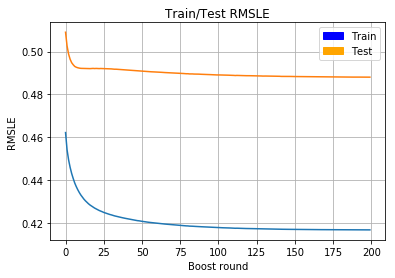

RMSLE Train set: 0.416996
RMSLE Test set: 0.488065


In [171]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.1, 'max_depth': 10, 'lambda': 5,
          'booster': 'gblinear', # 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

### Try with Gradiend Boost Linear Regression Tree

[0]	test-rmse:1.53203	train-rmse:1.21909	test-RMSLE:0.524812	train-RMSLE:0.482748
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53105	train-rmse:1.21774	test-RMSLE:0.523935	train-RMSLE:0.481347
[2]	test-rmse:1.53043	train-rmse:1.21636	test-RMSLE:0.523086	train-RMSLE:0.479934
[3]	test-rmse:1.52975	train-rmse:1.21504	test-RMSLE:0.522189	train-RMSLE:0.478524
[4]	test-rmse:1.52905	train-rmse:1.21389	test-RMSLE:0.521369	train-RMSLE:0.477232
[5]	test-rmse:1.52846	train-rmse:1.21261	test-RMSLE:0.52065	train-RMSLE:0.475944
[6]	test-rmse:1.52793	train-rmse:1.21134	test-RMSLE:0.519925	train-RMSLE:0.474595
[7]	test-rmse:1.52709	train-rmse:1.21014	test-RMSLE:0.51913	train-RMSLE:0.473331
[8]	test-rmse:1.52649	train-rmse:1.20897	test-RMSLE:0.518406	train-RMSLE:0.472068
[9]	test-rmse:1.52598	train-rmse:1.20779	test-RMSLE:0.517697	train-RMSLE:0.47086
[10]	test-rmse:1.52534	train-rmse:1.2

[98]	test-rmse:1.49422	train-rmse:1.13502	test-RMSLE:0.483549	train-RMSLE:0.400396
[99]	test-rmse:1.49394	train-rmse:1.13447	test-RMSLE:0.483343	train-RMSLE:0.399927
[100]	test-rmse:1.49373	train-rmse:1.13391	test-RMSLE:0.483232	train-RMSLE:0.399459
[101]	test-rmse:1.49351	train-rmse:1.13339	test-RMSLE:0.483038	train-RMSLE:0.39899
[102]	test-rmse:1.49323	train-rmse:1.13278	test-RMSLE:0.482989	train-RMSLE:0.39859
[103]	test-rmse:1.49303	train-rmse:1.13232	test-RMSLE:0.482825	train-RMSLE:0.398147
[104]	test-rmse:1.49283	train-rmse:1.13174	test-RMSLE:0.482731	train-RMSLE:0.397693
[105]	test-rmse:1.49259	train-rmse:1.13125	test-RMSLE:0.482609	train-RMSLE:0.397329
[106]	test-rmse:1.49253	train-rmse:1.13077	test-RMSLE:0.482543	train-RMSLE:0.396961
[107]	test-rmse:1.49238	train-rmse:1.13036	test-RMSLE:0.482431	train-RMSLE:0.396595
[108]	test-rmse:1.49226	train-rmse:1.12999	test-RMSLE:0.482259	train-RMSLE:0.396211
[109]	test-rmse:1.49201	train-rmse:1.12951	test-RMSLE:0.482142	train-RMSLE:0.395

[196]	test-rmse:1.48176	train-rmse:1.09464	test-RMSLE:0.479749	train-RMSLE:0.374168
[197]	test-rmse:1.48165	train-rmse:1.09434	test-RMSLE:0.479757	train-RMSLE:0.373976
[198]	test-rmse:1.48157	train-rmse:1.0939	test-RMSLE:0.479762	train-RMSLE:0.373741
[199]	test-rmse:1.48157	train-rmse:1.09355	test-RMSLE:0.479824	train-RMSLE:0.373615
[200]	test-rmse:1.48147	train-rmse:1.09325	test-RMSLE:0.479894	train-RMSLE:0.373489
[201]	test-rmse:1.48118	train-rmse:1.09302	test-RMSLE:0.47991	train-RMSLE:0.373323
[202]	test-rmse:1.48101	train-rmse:1.09271	test-RMSLE:0.479952	train-RMSLE:0.373173
[203]	test-rmse:1.48093	train-rmse:1.09241	test-RMSLE:0.480018	train-RMSLE:0.373077
[204]	test-rmse:1.48084	train-rmse:1.0921	test-RMSLE:0.480041	train-RMSLE:0.372942
[205]	test-rmse:1.48084	train-rmse:1.09167	test-RMSLE:0.480061	train-RMSLE:0.372744
[206]	test-rmse:1.48077	train-rmse:1.09137	test-RMSLE:0.480076	train-RMSLE:0.372611
[207]	test-rmse:1.48073	train-rmse:1.09112	test-RMSLE:0.480103	train-RMSLE:0.37

[294]	test-rmse:1.47687	train-rmse:1.06776	test-RMSLE:0.484674	train-RMSLE:0.364074
[295]	test-rmse:1.47685	train-rmse:1.06752	test-RMSLE:0.484662	train-RMSLE:0.363986
[296]	test-rmse:1.47675	train-rmse:1.0674	test-RMSLE:0.484721	train-RMSLE:0.363942
[297]	test-rmse:1.47668	train-rmse:1.06703	test-RMSLE:0.484749	train-RMSLE:0.363797
[298]	test-rmse:1.47662	train-rmse:1.06689	test-RMSLE:0.484794	train-RMSLE:0.36372
[299]	test-rmse:1.47661	train-rmse:1.06679	test-RMSLE:0.484766	train-RMSLE:0.363692
[300]	test-rmse:1.47659	train-rmse:1.0666	test-RMSLE:0.484877	train-RMSLE:0.363648
[301]	test-rmse:1.47658	train-rmse:1.0665	test-RMSLE:0.484939	train-RMSLE:0.363592
[302]	test-rmse:1.47655	train-rmse:1.06624	test-RMSLE:0.484925	train-RMSLE:0.363468
[303]	test-rmse:1.47652	train-rmse:1.06605	test-RMSLE:0.484974	train-RMSLE:0.36342
[304]	test-rmse:1.47645	train-rmse:1.06579	test-RMSLE:0.485109	train-RMSLE:0.363299
[305]	test-rmse:1.47648	train-rmse:1.06556	test-RMSLE:0.485155	train-RMSLE:0.3632

[393]	test-rmse:1.47571	train-rmse:1.04715	test-RMSLE:0.490742	train-RMSLE:0.358201
[394]	test-rmse:1.47572	train-rmse:1.04702	test-RMSLE:0.490805	train-RMSLE:0.358161
[395]	test-rmse:1.47569	train-rmse:1.04693	test-RMSLE:0.490851	train-RMSLE:0.358157
[396]	test-rmse:1.47572	train-rmse:1.04655	test-RMSLE:0.490924	train-RMSLE:0.358065
[397]	test-rmse:1.47573	train-rmse:1.04645	test-RMSLE:0.490993	train-RMSLE:0.358067
[398]	test-rmse:1.47569	train-rmse:1.04637	test-RMSLE:0.491044	train-RMSLE:0.358053
[399]	test-rmse:1.47566	train-rmse:1.04617	test-RMSLE:0.490927	train-RMSLE:0.35793
[400]	test-rmse:1.47565	train-rmse:1.04606	test-RMSLE:0.491092	train-RMSLE:0.357923
[401]	test-rmse:1.47564	train-rmse:1.04589	test-RMSLE:0.491234	train-RMSLE:0.357888
[402]	test-rmse:1.47565	train-rmse:1.04568	test-RMSLE:0.491305	train-RMSLE:0.35787
[403]	test-rmse:1.47568	train-rmse:1.04538	test-RMSLE:0.491293	train-RMSLE:0.357759
[404]	test-rmse:1.47573	train-rmse:1.04512	test-RMSLE:0.491371	train-RMSLE:0.3

[492]	test-rmse:1.47675	train-rmse:1.02975	test-RMSLE:0.496141	train-RMSLE:0.354432
[493]	test-rmse:1.47676	train-rmse:1.02951	test-RMSLE:0.496282	train-RMSLE:0.354369
[494]	test-rmse:1.47676	train-rmse:1.02934	test-RMSLE:0.496282	train-RMSLE:0.354312
[495]	test-rmse:1.47681	train-rmse:1.02924	test-RMSLE:0.496331	train-RMSLE:0.354283
[496]	test-rmse:1.47688	train-rmse:1.02907	test-RMSLE:0.496399	train-RMSLE:0.35424
[497]	test-rmse:1.4769	train-rmse:1.02892	test-RMSLE:0.496458	train-RMSLE:0.354204
[498]	test-rmse:1.47691	train-rmse:1.02885	test-RMSLE:0.496437	train-RMSLE:0.354188
[499]	test-rmse:1.47694	train-rmse:1.02878	test-RMSLE:0.496441	train-RMSLE:0.35419


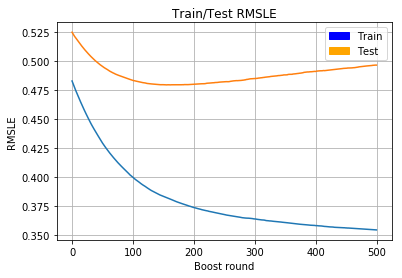

RMSLE Train set: 0.35419
RMSLE Test set: 0.496441


In [172]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 5,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53239	train-rmse:1.21915	test-RMSLE:0.52488	train-RMSLE:0.482753
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53171	train-rmse:1.21783	test-RMSLE:0.52403	train-RMSLE:0.481311
[2]	test-rmse:1.53119	train-rmse:1.21659	test-RMSLE:0.523197	train-RMSLE:0.479929
[3]	test-rmse:1.53056	train-rmse:1.21541	test-RMSLE:0.522305	train-RMSLE:0.478561
[4]	test-rmse:1.52998	train-rmse:1.21429	test-RMSLE:0.52149	train-RMSLE:0.477264
[5]	test-rmse:1.52938	train-rmse:1.21304	test-RMSLE:0.520711	train-RMSLE:0.475949
[6]	test-rmse:1.52885	train-rmse:1.21178	test-RMSLE:0.519903	train-RMSLE:0.47456
[7]	test-rmse:1.52823	train-rmse:1.21067	test-RMSLE:0.519115	train-RMSLE:0.473304
[8]	test-rmse:1.52766	train-rmse:1.20948	test-RMSLE:0.518385	train-RMSLE:0.47202
[9]	test-rmse:1.52725	train-rmse:1.20839	test-RMSLE:0.517643	train-RMSLE:0.470804
[10]	test-rmse:1.52672	train-rmse:1.207

[98]	test-rmse:1.50045	train-rmse:1.14143	test-RMSLE:0.481086	train-RMSLE:0.399862
[99]	test-rmse:1.5003	train-rmse:1.14095	test-RMSLE:0.480863	train-RMSLE:0.399372
[100]	test-rmse:1.50014	train-rmse:1.14039	test-RMSLE:0.480705	train-RMSLE:0.398863
[101]	test-rmse:1.49992	train-rmse:1.13992	test-RMSLE:0.480489	train-RMSLE:0.398407
[102]	test-rmse:1.4997	train-rmse:1.13939	test-RMSLE:0.480394	train-RMSLE:0.398021
[103]	test-rmse:1.49949	train-rmse:1.13894	test-RMSLE:0.480191	train-RMSLE:0.397577
[104]	test-rmse:1.4993	train-rmse:1.13833	test-RMSLE:0.480022	train-RMSLE:0.397048
[105]	test-rmse:1.4991	train-rmse:1.13787	test-RMSLE:0.479875	train-RMSLE:0.396674
[106]	test-rmse:1.499	train-rmse:1.1374	test-RMSLE:0.47978	train-RMSLE:0.396294
[107]	test-rmse:1.49887	train-rmse:1.1369	test-RMSLE:0.479618	train-RMSLE:0.395848
[108]	test-rmse:1.49872	train-rmse:1.13651	test-RMSLE:0.479435	train-RMSLE:0.395438
[109]	test-rmse:1.49858	train-rmse:1.13605	test-RMSLE:0.479282	train-RMSLE:0.395032
[11

[197]	test-rmse:1.48999	train-rmse:1.10164	test-RMSLE:0.473242	train-RMSLE:0.371097
[198]	test-rmse:1.48989	train-rmse:1.10122	test-RMSLE:0.473202	train-RMSLE:0.370841
[199]	test-rmse:1.48988	train-rmse:1.10086	test-RMSLE:0.473216	train-RMSLE:0.37069
[200]	test-rmse:1.48971	train-rmse:1.10051	test-RMSLE:0.473225	train-RMSLE:0.370536
[201]	test-rmse:1.48969	train-rmse:1.10029	test-RMSLE:0.473174	train-RMSLE:0.370379
[202]	test-rmse:1.48963	train-rmse:1.1	test-RMSLE:0.473137	train-RMSLE:0.370216
[203]	test-rmse:1.48957	train-rmse:1.09965	test-RMSLE:0.473134	train-RMSLE:0.370056
[204]	test-rmse:1.48944	train-rmse:1.0993	test-RMSLE:0.473114	train-RMSLE:0.369905
[205]	test-rmse:1.48938	train-rmse:1.09891	test-RMSLE:0.473094	train-RMSLE:0.369719
[206]	test-rmse:1.48931	train-rmse:1.09856	test-RMSLE:0.473102	train-RMSLE:0.369531
[207]	test-rmse:1.48921	train-rmse:1.0983	test-RMSLE:0.473108	train-RMSLE:0.369412
[208]	test-rmse:1.48917	train-rmse:1.09804	test-RMSLE:0.473107	train-RMSLE:0.369289

[296]	test-rmse:1.48409	train-rmse:1.07345	test-RMSLE:0.474851	train-RMSLE:0.359099
[297]	test-rmse:1.48403	train-rmse:1.07305	test-RMSLE:0.474894	train-RMSLE:0.35892
[298]	test-rmse:1.48399	train-rmse:1.07285	test-RMSLE:0.474902	train-RMSLE:0.358812
[299]	test-rmse:1.48396	train-rmse:1.07272	test-RMSLE:0.474939	train-RMSLE:0.358807
[300]	test-rmse:1.48388	train-rmse:1.07252	test-RMSLE:0.475008	train-RMSLE:0.358736
[301]	test-rmse:1.48386	train-rmse:1.07232	test-RMSLE:0.475011	train-RMSLE:0.358623
[302]	test-rmse:1.48385	train-rmse:1.07204	test-RMSLE:0.474966	train-RMSLE:0.358464
[303]	test-rmse:1.48384	train-rmse:1.07181	test-RMSLE:0.475	train-RMSLE:0.358406
[304]	test-rmse:1.48365	train-rmse:1.07157	test-RMSLE:0.475071	train-RMSLE:0.358282
[305]	test-rmse:1.48361	train-rmse:1.07138	test-RMSLE:0.475099	train-RMSLE:0.358218
[306]	test-rmse:1.48355	train-rmse:1.07113	test-RMSLE:0.475153	train-RMSLE:0.358156
[307]	test-rmse:1.48358	train-rmse:1.07088	test-RMSLE:0.475189	train-RMSLE:0.358

[394]	test-rmse:1.48113	train-rmse:1.05129	test-RMSLE:0.478116	train-RMSLE:0.352127
[395]	test-rmse:1.48107	train-rmse:1.05109	test-RMSLE:0.47812	train-RMSLE:0.352068
[396]	test-rmse:1.48107	train-rmse:1.05081	test-RMSLE:0.478184	train-RMSLE:0.352003
[397]	test-rmse:1.48105	train-rmse:1.05053	test-RMSLE:0.478199	train-RMSLE:0.351928
[398]	test-rmse:1.48103	train-rmse:1.05035	test-RMSLE:0.478233	train-RMSLE:0.351873
[399]	test-rmse:1.48101	train-rmse:1.05014	test-RMSLE:0.478181	train-RMSLE:0.351743
[400]	test-rmse:1.481	train-rmse:1.05004	test-RMSLE:0.478235	train-RMSLE:0.351755
[401]	test-rmse:1.48085	train-rmse:1.04987	test-RMSLE:0.478335	train-RMSLE:0.35173
[402]	test-rmse:1.48079	train-rmse:1.04973	test-RMSLE:0.478436	train-RMSLE:0.351746
[403]	test-rmse:1.48078	train-rmse:1.0495	test-RMSLE:0.478431	train-RMSLE:0.351655
[404]	test-rmse:1.48082	train-rmse:1.04922	test-RMSLE:0.478485	train-RMSLE:0.351589
[405]	test-rmse:1.48085	train-rmse:1.04897	test-RMSLE:0.47857	train-RMSLE:0.35155

[493]	test-rmse:1.47951	train-rmse:1.03212	test-RMSLE:0.481435	train-RMSLE:0.347302
[494]	test-rmse:1.47951	train-rmse:1.03194	test-RMSLE:0.481442	train-RMSLE:0.347217
[495]	test-rmse:1.4795	train-rmse:1.03176	test-RMSLE:0.481412	train-RMSLE:0.347142
[496]	test-rmse:1.47953	train-rmse:1.03161	test-RMSLE:0.481463	train-RMSLE:0.347106
[497]	test-rmse:1.47954	train-rmse:1.03143	test-RMSLE:0.481502	train-RMSLE:0.347057
[498]	test-rmse:1.47957	train-rmse:1.0312	test-RMSLE:0.4815	train-RMSLE:0.346952
[499]	test-rmse:1.4796	train-rmse:1.0311	test-RMSLE:0.481495	train-RMSLE:0.346968


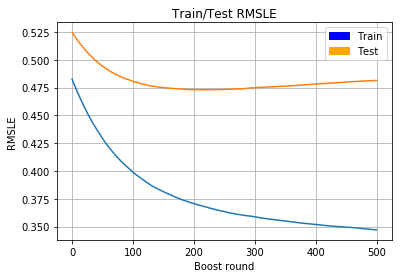

RMSLE Train set: 0.346968
RMSLE Test set: 0.481495


In [173]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 10,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53239	train-rmse:1.21927	test-RMSLE:0.524898	train-RMSLE:0.482825
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.5318	train-rmse:1.21809	test-RMSLE:0.524054	train-RMSLE:0.481468
[2]	test-rmse:1.53119	train-rmse:1.21695	test-RMSLE:0.523196	train-RMSLE:0.480149
[3]	test-rmse:1.53064	train-rmse:1.21587	test-RMSLE:0.522317	train-RMSLE:0.478806
[4]	test-rmse:1.53009	train-rmse:1.21479	test-RMSLE:0.521469	train-RMSLE:0.477488
[5]	test-rmse:1.52955	train-rmse:1.21362	test-RMSLE:0.520669	train-RMSLE:0.476191
[6]	test-rmse:1.529	train-rmse:1.21248	test-RMSLE:0.519869	train-RMSLE:0.474859
[7]	test-rmse:1.52839	train-rmse:1.21141	test-RMSLE:0.519059	train-RMSLE:0.473597
[8]	test-rmse:1.52788	train-rmse:1.21039	test-RMSLE:0.518335	train-RMSLE:0.472376
[9]	test-rmse:1.5275	train-rmse:1.20941	test-RMSLE:0.517615	train-RMSLE:0.471203
[10]	test-rmse:1.52703	train-rmse:1.20

[98]	test-rmse:1.5046	train-rmse:1.15061	test-RMSLE:0.480559	train-RMSLE:0.402522
[99]	test-rmse:1.50448	train-rmse:1.15023	test-RMSLE:0.480322	train-RMSLE:0.402076
[100]	test-rmse:1.5043	train-rmse:1.14977	test-RMSLE:0.480138	train-RMSLE:0.401601
[101]	test-rmse:1.50417	train-rmse:1.14933	test-RMSLE:0.479927	train-RMSLE:0.401111
[102]	test-rmse:1.50405	train-rmse:1.1489	test-RMSLE:0.47978	train-RMSLE:0.400706
[103]	test-rmse:1.50393	train-rmse:1.14856	test-RMSLE:0.479578	train-RMSLE:0.40029
[104]	test-rmse:1.50376	train-rmse:1.14806	test-RMSLE:0.479387	train-RMSLE:0.399809
[105]	test-rmse:1.50354	train-rmse:1.14767	test-RMSLE:0.479217	train-RMSLE:0.399456
[106]	test-rmse:1.50345	train-rmse:1.14728	test-RMSLE:0.479111	train-RMSLE:0.399092
[107]	test-rmse:1.50327	train-rmse:1.14688	test-RMSLE:0.478943	train-RMSLE:0.398681
[108]	test-rmse:1.50314	train-rmse:1.14649	test-RMSLE:0.478721	train-RMSLE:0.398219
[109]	test-rmse:1.50301	train-rmse:1.14612	test-RMSLE:0.478551	train-RMSLE:0.397826

[197]	test-rmse:1.49649	train-rmse:1.1161	test-RMSLE:0.471267	train-RMSLE:0.373776
[198]	test-rmse:1.49644	train-rmse:1.11573	test-RMSLE:0.471232	train-RMSLE:0.373527
[199]	test-rmse:1.49641	train-rmse:1.11539	test-RMSLE:0.471213	train-RMSLE:0.373343
[200]	test-rmse:1.49633	train-rmse:1.11513	test-RMSLE:0.471209	train-RMSLE:0.373203
[201]	test-rmse:1.49631	train-rmse:1.11494	test-RMSLE:0.471163	train-RMSLE:0.373065
[202]	test-rmse:1.49628	train-rmse:1.11473	test-RMSLE:0.471127	train-RMSLE:0.372911
[203]	test-rmse:1.49625	train-rmse:1.11439	test-RMSLE:0.471081	train-RMSLE:0.372714
[204]	test-rmse:1.49613	train-rmse:1.11407	test-RMSLE:0.471059	train-RMSLE:0.372537
[205]	test-rmse:1.49608	train-rmse:1.1138	test-RMSLE:0.471046	train-RMSLE:0.37237
[206]	test-rmse:1.49606	train-rmse:1.11351	test-RMSLE:0.471038	train-RMSLE:0.372188
[207]	test-rmse:1.49592	train-rmse:1.11329	test-RMSLE:0.471012	train-RMSLE:0.372068
[208]	test-rmse:1.49588	train-rmse:1.11306	test-RMSLE:0.471007	train-RMSLE:0.37

[296]	test-rmse:1.49226	train-rmse:1.09093	test-RMSLE:0.470908	train-RMSLE:0.361183
[297]	test-rmse:1.49224	train-rmse:1.09065	test-RMSLE:0.470949	train-RMSLE:0.361065
[298]	test-rmse:1.49222	train-rmse:1.09048	test-RMSLE:0.47095	train-RMSLE:0.360967
[299]	test-rmse:1.49222	train-rmse:1.09031	test-RMSLE:0.47096	train-RMSLE:0.360921
[300]	test-rmse:1.49213	train-rmse:1.0901	test-RMSLE:0.470943	train-RMSLE:0.360826
[301]	test-rmse:1.49213	train-rmse:1.08991	test-RMSLE:0.470926	train-RMSLE:0.360693
[302]	test-rmse:1.49211	train-rmse:1.08969	test-RMSLE:0.470923	train-RMSLE:0.360577
[303]	test-rmse:1.49209	train-rmse:1.08951	test-RMSLE:0.470946	train-RMSLE:0.360518
[304]	test-rmse:1.49204	train-rmse:1.08931	test-RMSLE:0.470962	train-RMSLE:0.360398
[305]	test-rmse:1.49203	train-rmse:1.08906	test-RMSLE:0.47095	train-RMSLE:0.360259
[306]	test-rmse:1.49191	train-rmse:1.08887	test-RMSLE:0.471035	train-RMSLE:0.360234
[307]	test-rmse:1.49191	train-rmse:1.08863	test-RMSLE:0.471039	train-RMSLE:0.360

[394]	test-rmse:1.49038	train-rmse:1.07034	test-RMSLE:0.4724	train-RMSLE:0.353403
[395]	test-rmse:1.49032	train-rmse:1.07017	test-RMSLE:0.472413	train-RMSLE:0.353341
[396]	test-rmse:1.49027	train-rmse:1.06996	test-RMSLE:0.472449	train-RMSLE:0.353307
[397]	test-rmse:1.49025	train-rmse:1.06971	test-RMSLE:0.472494	train-RMSLE:0.353229
[398]	test-rmse:1.4902	train-rmse:1.06954	test-RMSLE:0.472477	train-RMSLE:0.353159
[399]	test-rmse:1.49022	train-rmse:1.0694	test-RMSLE:0.472458	train-RMSLE:0.353084
[400]	test-rmse:1.49019	train-rmse:1.06924	test-RMSLE:0.472492	train-RMSLE:0.353052
[401]	test-rmse:1.49012	train-rmse:1.06906	test-RMSLE:0.472516	train-RMSLE:0.353023
[402]	test-rmse:1.49009	train-rmse:1.06889	test-RMSLE:0.472532	train-RMSLE:0.352965
[403]	test-rmse:1.4901	train-rmse:1.06871	test-RMSLE:0.472541	train-RMSLE:0.352893
[404]	test-rmse:1.49012	train-rmse:1.06848	test-RMSLE:0.47257	train-RMSLE:0.352834
[405]	test-rmse:1.49012	train-rmse:1.06821	test-RMSLE:0.4726	train-RMSLE:0.352727


[492]	test-rmse:1.48845	train-rmse:1.05223	test-RMSLE:0.47445	train-RMSLE:0.347887
[493]	test-rmse:1.48845	train-rmse:1.05204	test-RMSLE:0.474477	train-RMSLE:0.347826
[494]	test-rmse:1.48842	train-rmse:1.05184	test-RMSLE:0.474455	train-RMSLE:0.347718
[495]	test-rmse:1.48842	train-rmse:1.05168	test-RMSLE:0.474456	train-RMSLE:0.347663
[496]	test-rmse:1.48843	train-rmse:1.05153	test-RMSLE:0.474499	train-RMSLE:0.347643
[497]	test-rmse:1.48845	train-rmse:1.0514	test-RMSLE:0.474519	train-RMSLE:0.347593
[498]	test-rmse:1.48846	train-rmse:1.05123	test-RMSLE:0.474519	train-RMSLE:0.347529
[499]	test-rmse:1.48851	train-rmse:1.05113	test-RMSLE:0.47455	train-RMSLE:0.347532


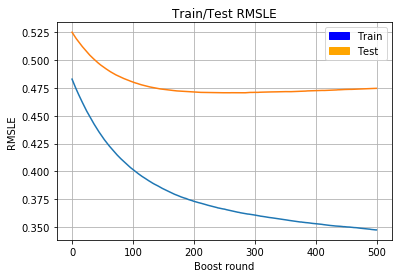

RMSLE Train set: 0.347532
RMSLE Test set: 0.47455


In [174]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 20,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53245	train-rmse:1.21931	test-RMSLE:0.524905	train-RMSLE:0.482831
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53191	train-rmse:1.21819	test-RMSLE:0.524073	train-RMSLE:0.4815
[2]	test-rmse:1.53138	train-rmse:1.21709	test-RMSLE:0.523219	train-RMSLE:0.480188
[3]	test-rmse:1.53089	train-rmse:1.21606	test-RMSLE:0.522368	train-RMSLE:0.478877
[4]	test-rmse:1.53036	train-rmse:1.21504	test-RMSLE:0.521534	train-RMSLE:0.477592
[5]	test-rmse:1.52984	train-rmse:1.21395	test-RMSLE:0.520745	train-RMSLE:0.476335
[6]	test-rmse:1.52931	train-rmse:1.21289	test-RMSLE:0.519948	train-RMSLE:0.475044
[7]	test-rmse:1.52878	train-rmse:1.21188	test-RMSLE:0.519181	train-RMSLE:0.473828
[8]	test-rmse:1.52824	train-rmse:1.2109	test-RMSLE:0.518425	train-RMSLE:0.472617
[9]	test-rmse:1.52785	train-rmse:1.20997	test-RMSLE:0.517691	train-RMSLE:0.471458
[10]	test-rmse:1.52742	train-rmse:1.2

[98]	test-rmse:1.50585	train-rmse:1.15584	test-RMSLE:0.480682	train-RMSLE:0.404737
[99]	test-rmse:1.50575	train-rmse:1.15551	test-RMSLE:0.480474	train-RMSLE:0.404324
[100]	test-rmse:1.50553	train-rmse:1.15507	test-RMSLE:0.480255	train-RMSLE:0.40384
[101]	test-rmse:1.50535	train-rmse:1.15471	test-RMSLE:0.480048	train-RMSLE:0.4034
[102]	test-rmse:1.50525	train-rmse:1.15433	test-RMSLE:0.479896	train-RMSLE:0.403002
[103]	test-rmse:1.50513	train-rmse:1.15401	test-RMSLE:0.479689	train-RMSLE:0.402591
[104]	test-rmse:1.50497	train-rmse:1.15359	test-RMSLE:0.47948	train-RMSLE:0.402132
[105]	test-rmse:1.50483	train-rmse:1.15326	test-RMSLE:0.479322	train-RMSLE:0.401793
[106]	test-rmse:1.50476	train-rmse:1.15291	test-RMSLE:0.47919	train-RMSLE:0.40141
[107]	test-rmse:1.50456	train-rmse:1.15255	test-RMSLE:0.478987	train-RMSLE:0.400986
[108]	test-rmse:1.50446	train-rmse:1.15221	test-RMSLE:0.478773	train-RMSLE:0.400536
[109]	test-rmse:1.50438	train-rmse:1.15187	test-RMSLE:0.478611	train-RMSLE:0.400135


[197]	test-rmse:1.4984	train-rmse:1.12523	test-RMSLE:0.47097	train-RMSLE:0.376758
[198]	test-rmse:1.49835	train-rmse:1.12494	test-RMSLE:0.470935	train-RMSLE:0.37655
[199]	test-rmse:1.49833	train-rmse:1.12464	test-RMSLE:0.470904	train-RMSLE:0.376361
[200]	test-rmse:1.49825	train-rmse:1.12439	test-RMSLE:0.470874	train-RMSLE:0.376209
[201]	test-rmse:1.49824	train-rmse:1.12423	test-RMSLE:0.470827	train-RMSLE:0.376068
[202]	test-rmse:1.49823	train-rmse:1.12403	test-RMSLE:0.470787	train-RMSLE:0.375902
[203]	test-rmse:1.49824	train-rmse:1.1237	test-RMSLE:0.470765	train-RMSLE:0.375689
[204]	test-rmse:1.49812	train-rmse:1.1234	test-RMSLE:0.470727	train-RMSLE:0.375502
[205]	test-rmse:1.49806	train-rmse:1.12319	test-RMSLE:0.47071	train-RMSLE:0.375376
[206]	test-rmse:1.49805	train-rmse:1.12295	test-RMSLE:0.4707	train-RMSLE:0.375226
[207]	test-rmse:1.49791	train-rmse:1.12274	test-RMSLE:0.470649	train-RMSLE:0.375104
[208]	test-rmse:1.49788	train-rmse:1.12253	test-RMSLE:0.470647	train-RMSLE:0.374987


[296]	test-rmse:1.49442	train-rmse:1.10294	test-RMSLE:0.470019	train-RMSLE:0.364563
[297]	test-rmse:1.49443	train-rmse:1.10269	test-RMSLE:0.470022	train-RMSLE:0.364429
[298]	test-rmse:1.49441	train-rmse:1.10254	test-RMSLE:0.470004	train-RMSLE:0.364323
[299]	test-rmse:1.49439	train-rmse:1.10233	test-RMSLE:0.469999	train-RMSLE:0.364237
[300]	test-rmse:1.49432	train-rmse:1.10215	test-RMSLE:0.469981	train-RMSLE:0.364129
[301]	test-rmse:1.49433	train-rmse:1.10194	test-RMSLE:0.469966	train-RMSLE:0.363985
[302]	test-rmse:1.49425	train-rmse:1.10176	test-RMSLE:0.46996	train-RMSLE:0.363897
[303]	test-rmse:1.49426	train-rmse:1.10157	test-RMSLE:0.47	train-RMSLE:0.363864
[304]	test-rmse:1.49421	train-rmse:1.10139	test-RMSLE:0.469965	train-RMSLE:0.363743
[305]	test-rmse:1.4942	train-rmse:1.10114	test-RMSLE:0.469949	train-RMSLE:0.363602
[306]	test-rmse:1.49401	train-rmse:1.10096	test-RMSLE:0.47001	train-RMSLE:0.363565
[307]	test-rmse:1.49402	train-rmse:1.10078	test-RMSLE:0.47001	train-RMSLE:0.363451


[395]	test-rmse:1.4929	train-rmse:1.0841	test-RMSLE:0.470914	train-RMSLE:0.356709
[396]	test-rmse:1.49288	train-rmse:1.08391	test-RMSLE:0.47096	train-RMSLE:0.356665
[397]	test-rmse:1.49276	train-rmse:1.08366	test-RMSLE:0.470986	train-RMSLE:0.356579
[398]	test-rmse:1.4927	train-rmse:1.08351	test-RMSLE:0.471013	train-RMSLE:0.35653
[399]	test-rmse:1.49272	train-rmse:1.08337	test-RMSLE:0.470996	train-RMSLE:0.356454
[400]	test-rmse:1.49273	train-rmse:1.08324	test-RMSLE:0.471034	train-RMSLE:0.356431
[401]	test-rmse:1.49266	train-rmse:1.08308	test-RMSLE:0.471059	train-RMSLE:0.356402
[402]	test-rmse:1.4926	train-rmse:1.08289	test-RMSLE:0.4711	train-RMSLE:0.356352
[403]	test-rmse:1.4926	train-rmse:1.08271	test-RMSLE:0.471096	train-RMSLE:0.356263
[404]	test-rmse:1.4926	train-rmse:1.08252	test-RMSLE:0.471112	train-RMSLE:0.356207
[405]	test-rmse:1.49259	train-rmse:1.08229	test-RMSLE:0.471143	train-RMSLE:0.356128
[406]	test-rmse:1.4926	train-rmse:1.08213	test-RMSLE:0.471137	train-RMSLE:0.356059
[40

[494]	test-rmse:1.4911	train-rmse:1.06728	test-RMSLE:0.472678	train-RMSLE:0.351117
[495]	test-rmse:1.4911	train-rmse:1.06712	test-RMSLE:0.472675	train-RMSLE:0.351052
[496]	test-rmse:1.49107	train-rmse:1.06696	test-RMSLE:0.472699	train-RMSLE:0.351009
[497]	test-rmse:1.49108	train-rmse:1.06683	test-RMSLE:0.472724	train-RMSLE:0.350961
[498]	test-rmse:1.49108	train-rmse:1.06667	test-RMSLE:0.472733	train-RMSLE:0.350893
[499]	test-rmse:1.49108	train-rmse:1.0666	test-RMSLE:0.472766	train-RMSLE:0.350914


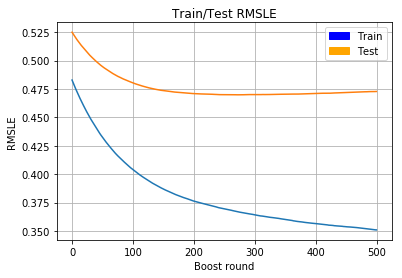

RMSLE Train set: 0.350914
RMSLE Test set: 0.472766


In [175]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 30,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53242	train-rmse:1.21938	test-RMSLE:0.524931	train-RMSLE:0.482909
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53182	train-rmse:1.21829	test-RMSLE:0.524098	train-RMSLE:0.481604
[2]	test-rmse:1.5313	train-rmse:1.21725	test-RMSLE:0.523266	train-RMSLE:0.480328
[3]	test-rmse:1.53084	train-rmse:1.21625	test-RMSLE:0.522413	train-RMSLE:0.479017
[4]	test-rmse:1.53035	train-rmse:1.21527	test-RMSLE:0.521596	train-RMSLE:0.477759
[5]	test-rmse:1.52988	train-rmse:1.21424	test-RMSLE:0.520833	train-RMSLE:0.47654
[6]	test-rmse:1.52939	train-rmse:1.21324	test-RMSLE:0.52005	train-RMSLE:0.475289
[7]	test-rmse:1.52886	train-rmse:1.21227	test-RMSLE:0.519297	train-RMSLE:0.474094
[8]	test-rmse:1.52831	train-rmse:1.21134	test-RMSLE:0.518547	train-RMSLE:0.472896
[9]	test-rmse:1.52791	train-rmse:1.21045	test-RMSLE:0.517839	train-RMSLE:0.471764
[10]	test-rmse:1.52747	train-rmse:1.2

[98]	test-rmse:1.50621	train-rmse:1.15955	test-RMSLE:0.480886	train-RMSLE:0.4067
[99]	test-rmse:1.50612	train-rmse:1.15924	test-RMSLE:0.48068	train-RMSLE:0.406301
[100]	test-rmse:1.50597	train-rmse:1.15886	test-RMSLE:0.480468	train-RMSLE:0.405853
[101]	test-rmse:1.50586	train-rmse:1.15852	test-RMSLE:0.480254	train-RMSLE:0.405406
[102]	test-rmse:1.50576	train-rmse:1.15816	test-RMSLE:0.480115	train-RMSLE:0.405024
[103]	test-rmse:1.50565	train-rmse:1.15781	test-RMSLE:0.479923	train-RMSLE:0.404597
[104]	test-rmse:1.50555	train-rmse:1.15744	test-RMSLE:0.479708	train-RMSLE:0.404146
[105]	test-rmse:1.50538	train-rmse:1.15711	test-RMSLE:0.479555	train-RMSLE:0.40381
[106]	test-rmse:1.50527	train-rmse:1.15678	test-RMSLE:0.479411	train-RMSLE:0.403441
[107]	test-rmse:1.50508	train-rmse:1.15646	test-RMSLE:0.479205	train-RMSLE:0.403027
[108]	test-rmse:1.50497	train-rmse:1.15614	test-RMSLE:0.478981	train-RMSLE:0.402588
[109]	test-rmse:1.5049	train-rmse:1.15579	test-RMSLE:0.478798	train-RMSLE:0.402182

[197]	test-rmse:1.49945	train-rmse:1.13178	test-RMSLE:0.471145	train-RMSLE:0.379867
[198]	test-rmse:1.49939	train-rmse:1.13155	test-RMSLE:0.471102	train-RMSLE:0.379682
[199]	test-rmse:1.49938	train-rmse:1.13129	test-RMSLE:0.471057	train-RMSLE:0.379503
[200]	test-rmse:1.49932	train-rmse:1.13109	test-RMSLE:0.471034	train-RMSLE:0.379373
[201]	test-rmse:1.4993	train-rmse:1.13091	test-RMSLE:0.470963	train-RMSLE:0.379205
[202]	test-rmse:1.49929	train-rmse:1.13074	test-RMSLE:0.470914	train-RMSLE:0.379043
[203]	test-rmse:1.49928	train-rmse:1.13047	test-RMSLE:0.470866	train-RMSLE:0.378853
[204]	test-rmse:1.4992	train-rmse:1.13024	test-RMSLE:0.470854	train-RMSLE:0.378717
[205]	test-rmse:1.49917	train-rmse:1.13004	test-RMSLE:0.470841	train-RMSLE:0.378595
[206]	test-rmse:1.49913	train-rmse:1.12983	test-RMSLE:0.470835	train-RMSLE:0.378464
[207]	test-rmse:1.49903	train-rmse:1.12965	test-RMSLE:0.470797	train-RMSLE:0.378356
[208]	test-rmse:1.49901	train-rmse:1.12946	test-RMSLE:0.470784	train-RMSLE:0.3

[295]	test-rmse:1.49588	train-rmse:1.11188	test-RMSLE:0.469828	train-RMSLE:0.368309
[296]	test-rmse:1.49585	train-rmse:1.11171	test-RMSLE:0.469823	train-RMSLE:0.368206
[297]	test-rmse:1.49583	train-rmse:1.11148	test-RMSLE:0.469846	train-RMSLE:0.368078
[298]	test-rmse:1.49583	train-rmse:1.11136	test-RMSLE:0.46983	train-RMSLE:0.367977
[299]	test-rmse:1.49582	train-rmse:1.11118	test-RMSLE:0.469818	train-RMSLE:0.367883
[300]	test-rmse:1.49575	train-rmse:1.11102	test-RMSLE:0.469789	train-RMSLE:0.367774
[301]	test-rmse:1.49576	train-rmse:1.11084	test-RMSLE:0.469764	train-RMSLE:0.367635
[302]	test-rmse:1.49568	train-rmse:1.11062	test-RMSLE:0.469771	train-RMSLE:0.367531
[303]	test-rmse:1.4957	train-rmse:1.11047	test-RMSLE:0.469825	train-RMSLE:0.36751
[304]	test-rmse:1.49564	train-rmse:1.11031	test-RMSLE:0.46979	train-RMSLE:0.367406
[305]	test-rmse:1.49566	train-rmse:1.11012	test-RMSLE:0.469767	train-RMSLE:0.367278
[306]	test-rmse:1.49553	train-rmse:1.10996	test-RMSLE:0.469814	train-RMSLE:0.367

[394]	test-rmse:1.49455	train-rmse:1.09451	test-RMSLE:0.470442	train-RMSLE:0.360469
[395]	test-rmse:1.49455	train-rmse:1.09436	test-RMSLE:0.470452	train-RMSLE:0.360417
[396]	test-rmse:1.49454	train-rmse:1.09417	test-RMSLE:0.470481	train-RMSLE:0.360362
[397]	test-rmse:1.49443	train-rmse:1.09395	test-RMSLE:0.470492	train-RMSLE:0.360261
[398]	test-rmse:1.49441	train-rmse:1.09381	test-RMSLE:0.470487	train-RMSLE:0.360187
[399]	test-rmse:1.49443	train-rmse:1.09369	test-RMSLE:0.470471	train-RMSLE:0.360117
[400]	test-rmse:1.49442	train-rmse:1.09357	test-RMSLE:0.470504	train-RMSLE:0.360093
[401]	test-rmse:1.49434	train-rmse:1.09342	test-RMSLE:0.47054	train-RMSLE:0.360068
[402]	test-rmse:1.49436	train-rmse:1.09325	test-RMSLE:0.470555	train-RMSLE:0.359996
[403]	test-rmse:1.49438	train-rmse:1.09308	test-RMSLE:0.470558	train-RMSLE:0.359906
[404]	test-rmse:1.49435	train-rmse:1.0929	test-RMSLE:0.470578	train-RMSLE:0.35986
[405]	test-rmse:1.49438	train-rmse:1.0927	test-RMSLE:0.470618	train-RMSLE:0.359

[493]	test-rmse:1.49339	train-rmse:1.07926	test-RMSLE:0.471854	train-RMSLE:0.355014
[494]	test-rmse:1.49334	train-rmse:1.0791	test-RMSLE:0.471827	train-RMSLE:0.354911
[495]	test-rmse:1.49335	train-rmse:1.07894	test-RMSLE:0.471811	train-RMSLE:0.354821
[496]	test-rmse:1.49332	train-rmse:1.0788	test-RMSLE:0.471837	train-RMSLE:0.354789
[497]	test-rmse:1.49333	train-rmse:1.07868	test-RMSLE:0.471859	train-RMSLE:0.354744
[498]	test-rmse:1.49333	train-rmse:1.07852	test-RMSLE:0.471874	train-RMSLE:0.35468
[499]	test-rmse:1.4933	train-rmse:1.07842	test-RMSLE:0.47187	train-RMSLE:0.354654


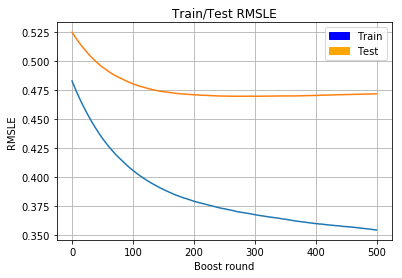

RMSLE Train set: 0.354654
RMSLE Test set: 0.47187


In [176]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 40,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53244	train-rmse:1.21943	test-RMSLE:0.524946	train-RMSLE:0.482942
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53185	train-rmse:1.21837	test-RMSLE:0.524129	train-RMSLE:0.48167
[2]	test-rmse:1.53131	train-rmse:1.21736	test-RMSLE:0.523299	train-RMSLE:0.480406
[3]	test-rmse:1.5308	train-rmse:1.21638	test-RMSLE:0.522459	train-RMSLE:0.479127
[4]	test-rmse:1.53034	train-rmse:1.21543	test-RMSLE:0.521658	train-RMSLE:0.477898
[5]	test-rmse:1.52987	train-rmse:1.21444	test-RMSLE:0.520914	train-RMSLE:0.476701
[6]	test-rmse:1.52938	train-rmse:1.21347	test-RMSLE:0.520139	train-RMSLE:0.475475
[7]	test-rmse:1.5289	train-rmse:1.21252	test-RMSLE:0.51941	train-RMSLE:0.474288
[8]	test-rmse:1.52841	train-rmse:1.21161	test-RMSLE:0.518685	train-RMSLE:0.473108
[9]	test-rmse:1.52802	train-rmse:1.21075	test-RMSLE:0.517982	train-RMSLE:0.472006
[10]	test-rmse:1.52758	train-rmse:1.20

[98]	test-rmse:1.50673	train-rmse:1.16226	test-RMSLE:0.481295	train-RMSLE:0.408451
[99]	test-rmse:1.50664	train-rmse:1.16198	test-RMSLE:0.481093	train-RMSLE:0.408081
[100]	test-rmse:1.5065	train-rmse:1.16163	test-RMSLE:0.480882	train-RMSLE:0.407653
[101]	test-rmse:1.50635	train-rmse:1.1613	test-RMSLE:0.480667	train-RMSLE:0.407231
[102]	test-rmse:1.50625	train-rmse:1.16098	test-RMSLE:0.480513	train-RMSLE:0.406863
[103]	test-rmse:1.50614	train-rmse:1.16065	test-RMSLE:0.480279	train-RMSLE:0.406423
[104]	test-rmse:1.50603	train-rmse:1.16032	test-RMSLE:0.480108	train-RMSLE:0.406026
[105]	test-rmse:1.50592	train-rmse:1.15999	test-RMSLE:0.47994	train-RMSLE:0.405668
[106]	test-rmse:1.50585	train-rmse:1.15966	test-RMSLE:0.47981	train-RMSLE:0.405296
[107]	test-rmse:1.50568	train-rmse:1.15936	test-RMSLE:0.4796	train-RMSLE:0.404887
[108]	test-rmse:1.50559	train-rmse:1.15906	test-RMSLE:0.479378	train-RMSLE:0.40446
[109]	test-rmse:1.50551	train-rmse:1.15871	test-RMSLE:0.479204	train-RMSLE:0.40406
[1

[197]	test-rmse:1.49981	train-rmse:1.13653	test-RMSLE:0.47113	train-RMSLE:0.382267
[198]	test-rmse:1.49975	train-rmse:1.13631	test-RMSLE:0.471084	train-RMSLE:0.382071
[199]	test-rmse:1.49973	train-rmse:1.13606	test-RMSLE:0.471068	train-RMSLE:0.381901
[200]	test-rmse:1.49968	train-rmse:1.13587	test-RMSLE:0.471026	train-RMSLE:0.381766
[201]	test-rmse:1.49968	train-rmse:1.13571	test-RMSLE:0.470954	train-RMSLE:0.381601
[202]	test-rmse:1.49967	train-rmse:1.13556	test-RMSLE:0.470904	train-RMSLE:0.381445
[203]	test-rmse:1.49964	train-rmse:1.13532	test-RMSLE:0.470857	train-RMSLE:0.381281
[204]	test-rmse:1.49954	train-rmse:1.13511	test-RMSLE:0.470825	train-RMSLE:0.381126
[205]	test-rmse:1.49953	train-rmse:1.13493	test-RMSLE:0.470794	train-RMSLE:0.381016
[206]	test-rmse:1.49948	train-rmse:1.13474	test-RMSLE:0.470773	train-RMSLE:0.380886
[207]	test-rmse:1.49938	train-rmse:1.13456	test-RMSLE:0.470728	train-RMSLE:0.380782
[208]	test-rmse:1.49936	train-rmse:1.1344	test-RMSLE:0.470718	train-RMSLE:0.3

[296]	test-rmse:1.49618	train-rmse:1.1182	test-RMSLE:0.469705	train-RMSLE:0.370999
[297]	test-rmse:1.49612	train-rmse:1.11801	test-RMSLE:0.469716	train-RMSLE:0.370904
[298]	test-rmse:1.49611	train-rmse:1.11791	test-RMSLE:0.469695	train-RMSLE:0.370806
[299]	test-rmse:1.49609	train-rmse:1.11774	test-RMSLE:0.469676	train-RMSLE:0.370709
[300]	test-rmse:1.49601	train-rmse:1.11759	test-RMSLE:0.469679	train-RMSLE:0.370624
[301]	test-rmse:1.49602	train-rmse:1.11744	test-RMSLE:0.469662	train-RMSLE:0.370503
[302]	test-rmse:1.49592	train-rmse:1.11726	test-RMSLE:0.469666	train-RMSLE:0.370414
[303]	test-rmse:1.49594	train-rmse:1.11711	test-RMSLE:0.469712	train-RMSLE:0.370393
[304]	test-rmse:1.49592	train-rmse:1.11696	test-RMSLE:0.469681	train-RMSLE:0.370294
[305]	test-rmse:1.49596	train-rmse:1.11679	test-RMSLE:0.469672	train-RMSLE:0.370187
[306]	test-rmse:1.49582	train-rmse:1.11665	test-RMSLE:0.469677	train-RMSLE:0.370134
[307]	test-rmse:1.49576	train-rmse:1.1165	test-RMSLE:0.469695	train-RMSLE:0.3

[394]	test-rmse:1.49436	train-rmse:1.10269	test-RMSLE:0.470281	train-RMSLE:0.36389
[395]	test-rmse:1.4943	train-rmse:1.10255	test-RMSLE:0.470274	train-RMSLE:0.363836
[396]	test-rmse:1.49428	train-rmse:1.10238	test-RMSLE:0.470296	train-RMSLE:0.363778
[397]	test-rmse:1.49427	train-rmse:1.10216	test-RMSLE:0.470316	train-RMSLE:0.363668
[398]	test-rmse:1.49421	train-rmse:1.10203	test-RMSLE:0.470308	train-RMSLE:0.3636
[399]	test-rmse:1.49422	train-rmse:1.10192	test-RMSLE:0.470294	train-RMSLE:0.363542
[400]	test-rmse:1.49422	train-rmse:1.10181	test-RMSLE:0.470317	train-RMSLE:0.363517
[401]	test-rmse:1.49416	train-rmse:1.10168	test-RMSLE:0.470344	train-RMSLE:0.36349
[402]	test-rmse:1.49408	train-rmse:1.10152	test-RMSLE:0.47037	train-RMSLE:0.363444
[403]	test-rmse:1.49404	train-rmse:1.10136	test-RMSLE:0.470352	train-RMSLE:0.363347
[404]	test-rmse:1.49399	train-rmse:1.10119	test-RMSLE:0.470357	train-RMSLE:0.363284
[405]	test-rmse:1.49402	train-rmse:1.101	test-RMSLE:0.470384	train-RMSLE:0.363213


[493]	test-rmse:1.49338	train-rmse:1.08849	test-RMSLE:0.471456	train-RMSLE:0.358461
[494]	test-rmse:1.49331	train-rmse:1.08834	test-RMSLE:0.471446	train-RMSLE:0.358368
[495]	test-rmse:1.49332	train-rmse:1.0882	test-RMSLE:0.471421	train-RMSLE:0.358276
[496]	test-rmse:1.49331	train-rmse:1.08807	test-RMSLE:0.471449	train-RMSLE:0.358252
[497]	test-rmse:1.49334	train-rmse:1.08796	test-RMSLE:0.471456	train-RMSLE:0.358205
[498]	test-rmse:1.49334	train-rmse:1.08781	test-RMSLE:0.471469	train-RMSLE:0.358151
[499]	test-rmse:1.49332	train-rmse:1.08773	test-RMSLE:0.47147	train-RMSLE:0.358127


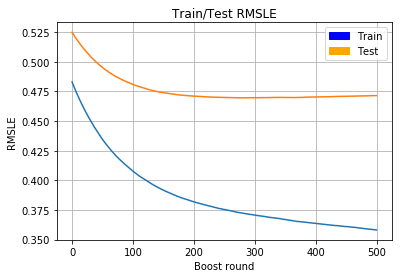

RMSLE Train set: 0.358127
RMSLE Test set: 0.47147


In [177]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 50,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

[0]	test-rmse:1.53185	train-rmse:1.21837	test-RMSLE:0.524159	train-RMSLE:0.481708
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.5307	train-rmse:1.21628	test-RMSLE:0.522554	train-RMSLE:0.479188
[2]	test-rmse:1.52966	train-rmse:1.21433	test-RMSLE:0.520946	train-RMSLE:0.476724
[3]	test-rmse:1.52869	train-rmse:1.21245	test-RMSLE:0.519334	train-RMSLE:0.474252
[4]	test-rmse:1.52786	train-rmse:1.21068	test-RMSLE:0.517822	train-RMSLE:0.471901
[5]	test-rmse:1.52704	train-rmse:1.20885	test-RMSLE:0.516441	train-RMSLE:0.469656
[6]	test-rmse:1.52615	train-rmse:1.20705	test-RMSLE:0.514994	train-RMSLE:0.467366
[7]	test-rmse:1.52528	train-rmse:1.20535	test-RMSLE:0.513684	train-RMSLE:0.465184
[8]	test-rmse:1.52434	train-rmse:1.20371	test-RMSLE:0.512368	train-RMSLE:0.463026
[9]	test-rmse:1.52367	train-rmse:1.20219	test-RMSLE:0.511139	train-RMSLE:0.461051
[10]	test-rmse:1.52292	train-rmse:1

[98]	test-rmse:1.5004	train-rmse:1.1365	test-RMSLE:0.471835	train-RMSLE:0.382659
[99]	test-rmse:1.5004	train-rmse:1.13615	test-RMSLE:0.471754	train-RMSLE:0.382362
[100]	test-rmse:1.50021	train-rmse:1.13567	test-RMSLE:0.471625	train-RMSLE:0.381949
[101]	test-rmse:1.50014	train-rmse:1.1353	test-RMSLE:0.471508	train-RMSLE:0.381571
[102]	test-rmse:1.5001	train-rmse:1.13484	test-RMSLE:0.471512	train-RMSLE:0.381336
[103]	test-rmse:1.50006	train-rmse:1.13444	test-RMSLE:0.471408	train-RMSLE:0.380948
[104]	test-rmse:1.49997	train-rmse:1.13394	test-RMSLE:0.471335	train-RMSLE:0.38058
[105]	test-rmse:1.49986	train-rmse:1.13352	test-RMSLE:0.471294	train-RMSLE:0.380347
[106]	test-rmse:1.49977	train-rmse:1.13322	test-RMSLE:0.47131	train-RMSLE:0.380167
[107]	test-rmse:1.49968	train-rmse:1.13281	test-RMSLE:0.471158	train-RMSLE:0.379791
[108]	test-rmse:1.49968	train-rmse:1.1325	test-RMSLE:0.471061	train-RMSLE:0.379484
[109]	test-rmse:1.49968	train-rmse:1.13208	test-RMSLE:0.471008	train-RMSLE:0.379169
[1

[197]	test-rmse:1.49548	train-rmse:1.10299	test-RMSLE:0.471195	train-RMSLE:0.364279
[198]	test-rmse:1.49547	train-rmse:1.10261	test-RMSLE:0.471239	train-RMSLE:0.364092
[199]	test-rmse:1.49547	train-rmse:1.10225	test-RMSLE:0.471231	train-RMSLE:0.363914
[200]	test-rmse:1.49548	train-rmse:1.10202	test-RMSLE:0.471288	train-RMSLE:0.363878
[201]	test-rmse:1.49548	train-rmse:1.10181	test-RMSLE:0.471296	train-RMSLE:0.363777
[202]	test-rmse:1.49549	train-rmse:1.10157	test-RMSLE:0.471209	train-RMSLE:0.363551
[203]	test-rmse:1.49546	train-rmse:1.10119	test-RMSLE:0.471227	train-RMSLE:0.36344
[204]	test-rmse:1.49533	train-rmse:1.10088	test-RMSLE:0.471297	train-RMSLE:0.363346
[205]	test-rmse:1.49536	train-rmse:1.10066	test-RMSLE:0.471378	train-RMSLE:0.363333
[206]	test-rmse:1.4953	train-rmse:1.10043	test-RMSLE:0.471427	train-RMSLE:0.363244
[207]	test-rmse:1.49527	train-rmse:1.10019	test-RMSLE:0.471498	train-RMSLE:0.363243
[208]	test-rmse:1.49527	train-rmse:1.09999	test-RMSLE:0.471552	train-RMSLE:0.3

[296]	test-rmse:1.49364	train-rmse:1.07638	test-RMSLE:0.474318	train-RMSLE:0.354772
[297]	test-rmse:1.49358	train-rmse:1.07606	test-RMSLE:0.474358	train-RMSLE:0.354601
[298]	test-rmse:1.49358	train-rmse:1.07591	test-RMSLE:0.474352	train-RMSLE:0.354493
[299]	test-rmse:1.49364	train-rmse:1.0757	test-RMSLE:0.474382	train-RMSLE:0.354467
[300]	test-rmse:1.49359	train-rmse:1.07544	test-RMSLE:0.474394	train-RMSLE:0.354309
[301]	test-rmse:1.49359	train-rmse:1.0752	test-RMSLE:0.474309	train-RMSLE:0.354072
[302]	test-rmse:1.49351	train-rmse:1.07489	test-RMSLE:0.474317	train-RMSLE:0.353935
[303]	test-rmse:1.49357	train-rmse:1.07466	test-RMSLE:0.47439	train-RMSLE:0.353931
[304]	test-rmse:1.49352	train-rmse:1.07439	test-RMSLE:0.474343	train-RMSLE:0.353742
[305]	test-rmse:1.49354	train-rmse:1.07415	test-RMSLE:0.474324	train-RMSLE:0.353613
[306]	test-rmse:1.4933	train-rmse:1.07394	test-RMSLE:0.474405	train-RMSLE:0.353582
[307]	test-rmse:1.49325	train-rmse:1.07366	test-RMSLE:0.474415	train-RMSLE:0.353

[394]	test-rmse:1.4936	train-rmse:1.05175	test-RMSLE:0.476592	train-RMSLE:0.345795
[395]	test-rmse:1.49361	train-rmse:1.05153	test-RMSLE:0.476563	train-RMSLE:0.345657
[396]	test-rmse:1.49364	train-rmse:1.05126	test-RMSLE:0.476635	train-RMSLE:0.345615
[397]	test-rmse:1.49366	train-rmse:1.0509	test-RMSLE:0.476693	train-RMSLE:0.345451
[398]	test-rmse:1.49368	train-rmse:1.05067	test-RMSLE:0.476693	train-RMSLE:0.345339
[399]	test-rmse:1.49373	train-rmse:1.05048	test-RMSLE:0.476666	train-RMSLE:0.345232
[400]	test-rmse:1.49372	train-rmse:1.05031	test-RMSLE:0.476714	train-RMSLE:0.345218
[401]	test-rmse:1.4937	train-rmse:1.05007	test-RMSLE:0.476766	train-RMSLE:0.345164
[402]	test-rmse:1.49376	train-rmse:1.04983	test-RMSLE:0.476758	train-RMSLE:0.345056
[403]	test-rmse:1.49378	train-rmse:1.04957	test-RMSLE:0.476762	train-RMSLE:0.344937
[404]	test-rmse:1.49372	train-rmse:1.04929	test-RMSLE:0.476782	train-RMSLE:0.344858
[405]	test-rmse:1.49378	train-rmse:1.04901	test-RMSLE:0.476801	train-RMSLE:0.34

[492]	test-rmse:1.4943	train-rmse:1.02818	test-RMSLE:0.47914	train-RMSLE:0.33757
[493]	test-rmse:1.49432	train-rmse:1.02796	test-RMSLE:0.479141	train-RMSLE:0.337501
[494]	test-rmse:1.49422	train-rmse:1.0277	test-RMSLE:0.47912	train-RMSLE:0.337319
[495]	test-rmse:1.49426	train-rmse:1.02742	test-RMSLE:0.479117	train-RMSLE:0.337205
[496]	test-rmse:1.49426	train-rmse:1.0272	test-RMSLE:0.479152	train-RMSLE:0.337157
[497]	test-rmse:1.4943	train-rmse:1.02703	test-RMSLE:0.479165	train-RMSLE:0.33708
[498]	test-rmse:1.49429	train-rmse:1.02679	test-RMSLE:0.479196	train-RMSLE:0.336981
[499]	test-rmse:1.49433	train-rmse:1.02668	test-RMSLE:0.479246	train-RMSLE:0.337007


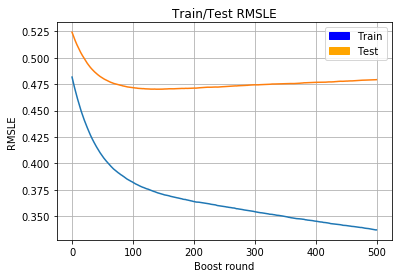

RMSLE Train set: 0.337007
RMSLE Test set: 0.479246


In [178]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.02, 'max_depth': 10, 'lambda': 50,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])

# Final Result

[0]	test-rmse:1.53242	train-rmse:1.21938	test-RMSLE:0.524931	train-RMSLE:0.482909
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.53182	train-rmse:1.21829	test-RMSLE:0.524098	train-RMSLE:0.481604
[2]	test-rmse:1.5313	train-rmse:1.21725	test-RMSLE:0.523266	train-RMSLE:0.480328
[3]	test-rmse:1.53084	train-rmse:1.21625	test-RMSLE:0.522413	train-RMSLE:0.479017
[4]	test-rmse:1.53035	train-rmse:1.21527	test-RMSLE:0.521596	train-RMSLE:0.477759
[5]	test-rmse:1.52988	train-rmse:1.21424	test-RMSLE:0.520833	train-RMSLE:0.47654
[6]	test-rmse:1.52939	train-rmse:1.21324	test-RMSLE:0.52005	train-RMSLE:0.475289
[7]	test-rmse:1.52886	train-rmse:1.21227	test-RMSLE:0.519297	train-RMSLE:0.474094
[8]	test-rmse:1.52831	train-rmse:1.21134	test-RMSLE:0.518547	train-RMSLE:0.472896
[9]	test-rmse:1.52791	train-rmse:1.21045	test-RMSLE:0.517839	train-RMSLE:0.471764
[10]	test-rmse:1.52747	train-rmse:1.2

[98]	test-rmse:1.50621	train-rmse:1.15955	test-RMSLE:0.480886	train-RMSLE:0.4067
[99]	test-rmse:1.50612	train-rmse:1.15924	test-RMSLE:0.48068	train-RMSLE:0.406301
[100]	test-rmse:1.50597	train-rmse:1.15886	test-RMSLE:0.480468	train-RMSLE:0.405853
[101]	test-rmse:1.50586	train-rmse:1.15852	test-RMSLE:0.480254	train-RMSLE:0.405406
[102]	test-rmse:1.50576	train-rmse:1.15816	test-RMSLE:0.480115	train-RMSLE:0.405024
[103]	test-rmse:1.50565	train-rmse:1.15781	test-RMSLE:0.479923	train-RMSLE:0.404597
[104]	test-rmse:1.50555	train-rmse:1.15744	test-RMSLE:0.479708	train-RMSLE:0.404146
[105]	test-rmse:1.50538	train-rmse:1.15711	test-RMSLE:0.479555	train-RMSLE:0.40381
[106]	test-rmse:1.50527	train-rmse:1.15678	test-RMSLE:0.479411	train-RMSLE:0.403441
[107]	test-rmse:1.50508	train-rmse:1.15646	test-RMSLE:0.479205	train-RMSLE:0.403027
[108]	test-rmse:1.50497	train-rmse:1.15614	test-RMSLE:0.478981	train-RMSLE:0.402588
[109]	test-rmse:1.5049	train-rmse:1.15579	test-RMSLE:0.478798	train-RMSLE:0.402182

[197]	test-rmse:1.49945	train-rmse:1.13178	test-RMSLE:0.471145	train-RMSLE:0.379867
[198]	test-rmse:1.49939	train-rmse:1.13155	test-RMSLE:0.471102	train-RMSLE:0.379682
[199]	test-rmse:1.49938	train-rmse:1.13129	test-RMSLE:0.471057	train-RMSLE:0.379503
[200]	test-rmse:1.49932	train-rmse:1.13109	test-RMSLE:0.471034	train-RMSLE:0.379373
[201]	test-rmse:1.4993	train-rmse:1.13091	test-RMSLE:0.470963	train-RMSLE:0.379205
[202]	test-rmse:1.49929	train-rmse:1.13074	test-RMSLE:0.470914	train-RMSLE:0.379043
[203]	test-rmse:1.49928	train-rmse:1.13047	test-RMSLE:0.470866	train-RMSLE:0.378853
[204]	test-rmse:1.4992	train-rmse:1.13024	test-RMSLE:0.470854	train-RMSLE:0.378717
[205]	test-rmse:1.49917	train-rmse:1.13004	test-RMSLE:0.470841	train-RMSLE:0.378595
[206]	test-rmse:1.49913	train-rmse:1.12983	test-RMSLE:0.470835	train-RMSLE:0.378464
[207]	test-rmse:1.49903	train-rmse:1.12965	test-RMSLE:0.470797	train-RMSLE:0.378356
[208]	test-rmse:1.49901	train-rmse:1.12946	test-RMSLE:0.470784	train-RMSLE:0.3

[295]	test-rmse:1.49588	train-rmse:1.11188	test-RMSLE:0.469828	train-RMSLE:0.368309
[296]	test-rmse:1.49585	train-rmse:1.11171	test-RMSLE:0.469823	train-RMSLE:0.368206
[297]	test-rmse:1.49583	train-rmse:1.11148	test-RMSLE:0.469846	train-RMSLE:0.368078
[298]	test-rmse:1.49583	train-rmse:1.11136	test-RMSLE:0.46983	train-RMSLE:0.367977
[299]	test-rmse:1.49582	train-rmse:1.11118	test-RMSLE:0.469818	train-RMSLE:0.367883


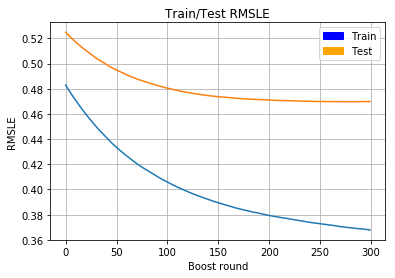

RMSLE Train set: 0.367883
RMSLE Test set: 0.469818


In [179]:
# XGBoost
params = {'objective': 'reg:linear',  'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'lambda': 40,
          'booster': 'gbtree', 'tree_method': 'gpu_hist',
         }
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=300, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])
print('RMSLE Test set:', xgb_results['test']['RMSLE'][-1])